In [1]:
import sys
import os
sys.path.insert(0, "../../python")

import numpy as np
from beam.beams import electronbeam
import matplotlib.pyplot as plt
from beam import interactions
from ionization import ionization
from lens import profile
import matplotlib.gridspec as gridspec
import beam.calc.electron as ecalc
import scipy.constants as const
from scipy.interpolate import interp1d
import beam.calc.electron as ecalc

path = '/media/robert/Data_Storage/Data/NonlinearFocusing/'

In [2]:
# Non-linear focusing with the example ramp from the paper
# Plasma parameters
N = 40000
Zmin = -100
gb0 = 20000
ne0 = 2*gb0/5.95074e4**2
dgdz0 = 0.0
a = 0.2
z = np.linspace(Zmin, 0, N)
frac = 1/(1+(a*z)**2)
sel = frac < 0.012
tran = z[sel][-1]
ztran = z[sel]
sigma = 2.645
frac[sel] = frac[sel][-1]*np.exp(-(ztran - tran)**2/(2*sigma**2))
ne = frac*ne0
# Beam parameters
bs0 = 10
ss = 48.041
delta = 0.01
beta0 = (Zmin+ss)**2/bs0+bs0
alpha0 = -(Zmin+ss)/bs0
betam = 1/np.sqrt(frac)

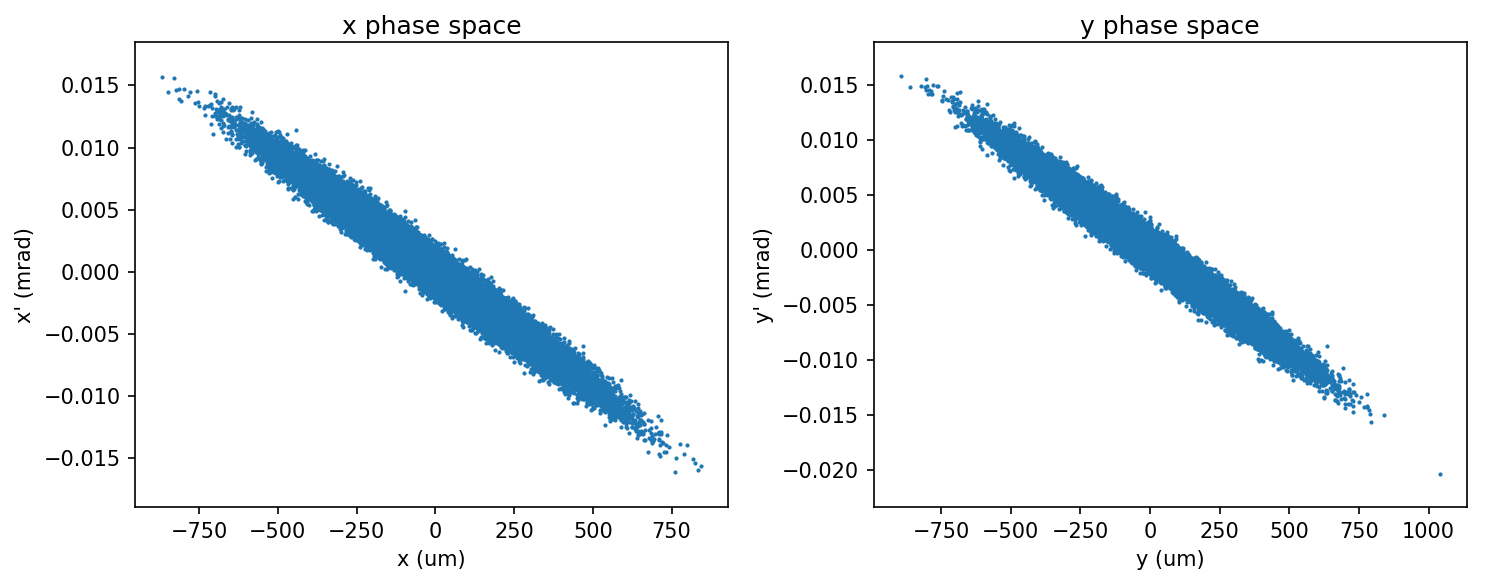

In [3]:
# Linear focusing
electronParams = {
    'name' : 'LinearRamp',
    'path' : path,
    'load' : False,
    'N' : 100000,
    'gamma' : gb0,
    'emittance' : 3.0e-6,
    'betax' : beta0,
    'betay' : beta0,
    'alphax' : alpha0,
    'alphay' : alpha0,
    'sigmaz' : 5e-6,
    'dE' : delta
}

beam = electronbeam.GaussianElectronBeam(electronParams)
#beam = electronbeam.ElectronBeam(electronParams)
beam.plot_current_phase()

class plasmaCls():
    def __init__(self):
        """ Empy init function """
    def get_ne(self, z):
        return ne
    def dgammadz(self, ne):
        return 0.0
    
plasmaDen = plasmaCls()
dumpPer = 50
interactions.electron_plasma(beam, plasmaDen, z*1e6, dumpPer, 4)
beta, alpha, gamma, gb = ecalc.cs_propagation(z, ne, beta0, alpha0, gb0, dgdz0, ne0)
m = int(N/dumpPer)
beam_z, dz = np.linspace(Zmin, 0, m, retstep=True)
beam_ne = interp1d(z, ne)(beam_z)
beam_bm = interp1d(z, betam)(beam_z)

Initial emittance: 3.0097 um rad
Final emittance:   3.0099 um rad


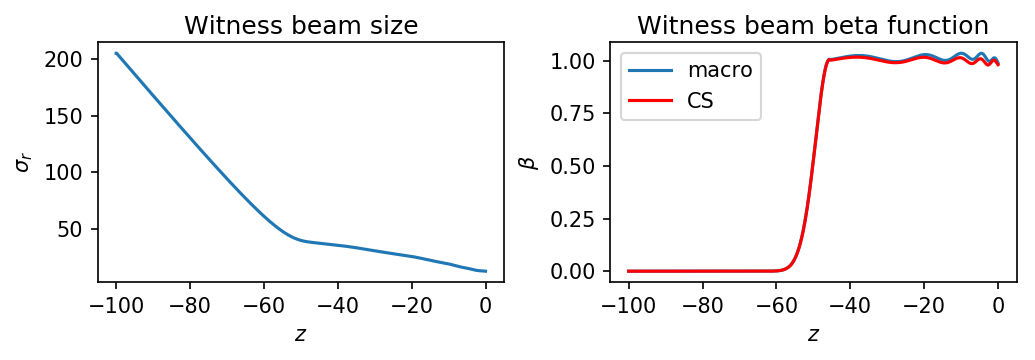

In [4]:
beam_sigmar = np.zeros(m, dtype='double')
beam_eps = np.zeros(m, dtype='double')
for i in range(m):
    beam_sigmar[i] = np.average(beam.get_sigmar(i))
    beam_eps[i] = np.average(beam.get_emittance_n(i))
beam_beta = (beam_sigmar)**2 / beam_eps * gb0
print('Initial emittance: %0.4f um rad' % (beam_eps[0]*1e6))
print('Final emittance:   %0.4f um rad' % (beam_eps[m-1]*1e6))

plt.figure(figsize=(7, 2.5), dpi=150)
gs = gridspec.GridSpec(1, 2)
plt.subplot(gs[0,0])
plt.plot(beam_z, beam_sigmar*1e6)
plt.title('Witness beam size')
plt.xlabel(r'$z$')
plt.ylabel(r'$\sigma_r$')

plt.subplot(gs[0,1])
plt.plot(beam_z, beam_beta/beam_bm)
plt.plot(z, beta/betam, 'r')
plt.title('Witness beam beta function')
plt.xlabel(r'$z$')
plt.ylabel(r'$\beta$')
plt.legend(['macro', 'CS'])

plt.tight_layout()
plt.show()

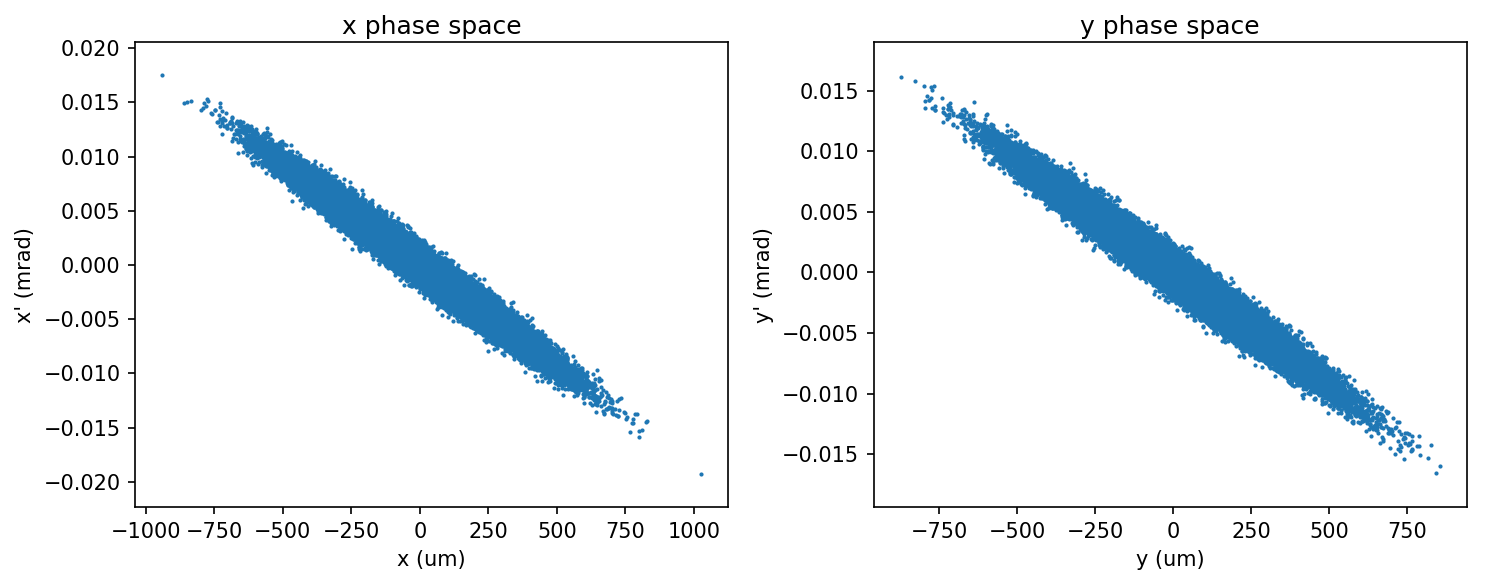

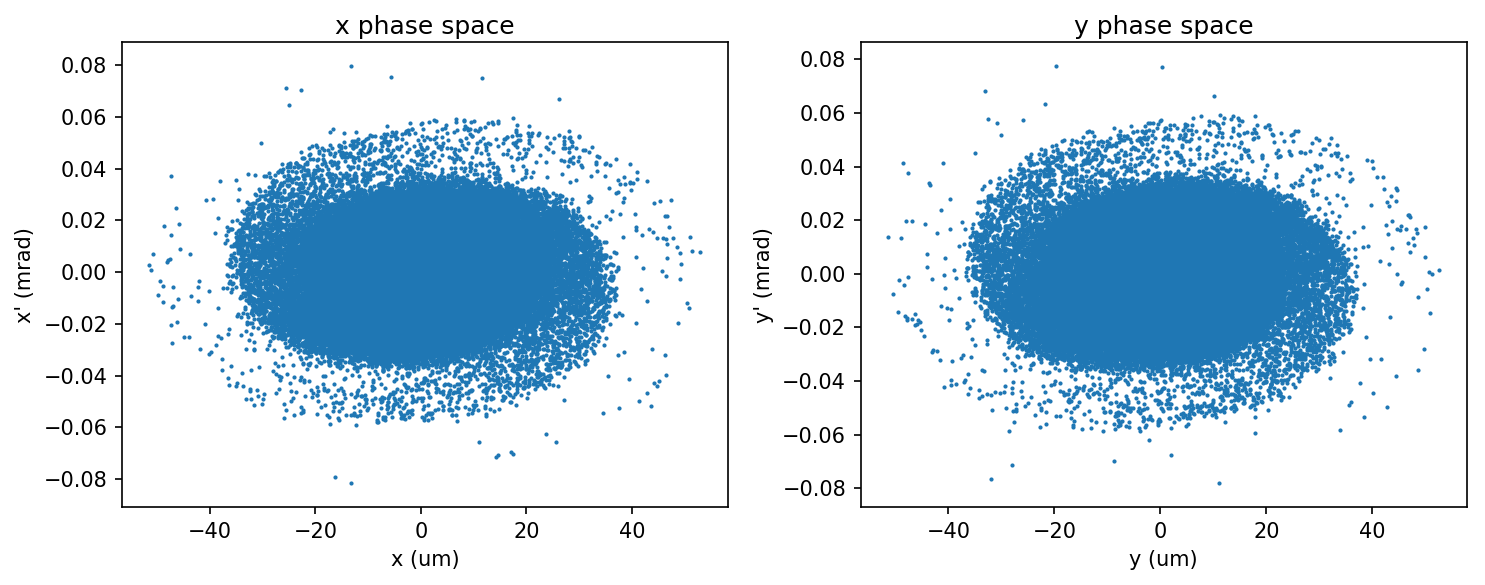

In [5]:
#Non-linear focusing
electronParams['name'] = 'NonLinearRamp'

beam2 = electronbeam.GaussianElectronBeam(electronParams)
#beam = electronbeam.ElectronBeam(electronParams)
beam2.plot_current_phase()

class plasmaCls():
    def __init__(self):
        """ Empy init function """
    def get_ne(self, z):
        return ne
    def dgammadz(self, ne):
        return 0.0
    
plasmaDen = plasmaCls()
dumpPer = 50
beam2.ptcls = ecalc.electron_propagation_nonlinear(beam2.ptcls,
                            z, 0.0, ne, dumpPer,
                            beam2.save_ptcls, plasmaDen.dgammadz, 4, 1e4)

beta, alpha, gamma, gb = ecalc.cs_propagation(z, ne, beta0, alpha0, gb0, dgdz0, ne0)
m = int(N/dumpPer)
beam_z, dz = np.linspace(Zmin, 0, m, retstep=True)
beam_ne = interp1d(z, ne)(beam_z)
beam_bm = interp1d(z, betam)(beam_z)
beam2.plot_current_phase()

Initial emittance: 2.9953 um rad
Final emittance:   3.2782 um rad


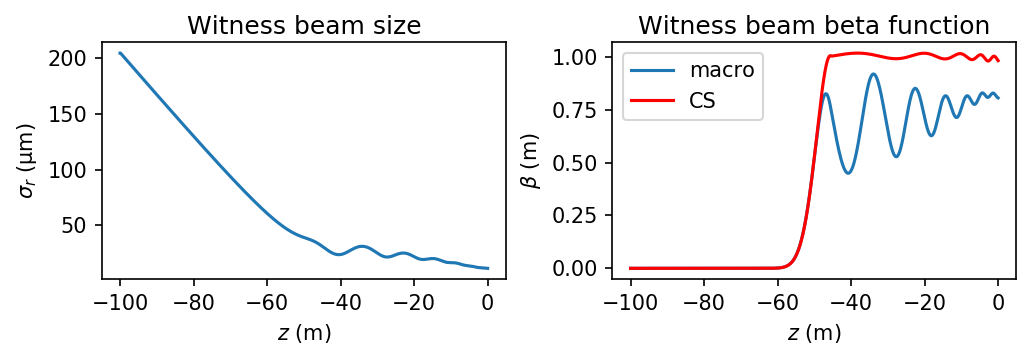

In [6]:
beam_sigmar = np.zeros(m, dtype='double')
beam_eps = np.zeros(m, dtype='double')
for i in range(m):
    beam_sigmar[i] = np.average(beam2.get_sigmar(i))
    beam_eps[i] = np.average(beam2.get_emittance_n(i))
beam_beta = (beam_sigmar)**2 / beam_eps * gb0
print('Initial emittance: %0.4f um rad' % (beam_eps[0]*1e6))
print('Final emittance:   %0.4f um rad' % (beam_eps[m-1]*1e6))

plt.figure(figsize=(7, 2.5), dpi=150)
gs = gridspec.GridSpec(1, 2)
plt.subplot(gs[0,0])
plt.plot(beam_z, beam_sigmar*1e6)
plt.title('Witness beam size')
plt.xlabel(r'$z$ (m)')
plt.ylabel(r'$\sigma_r$ ($\mathrm{\mu m}$)')

plt.subplot(gs[0,1])
plt.plot(beam_z, beam_beta/beam_bm)
plt.plot(z, beta/betam, 'r')
plt.title('Witness beam beta function')
plt.xlabel(r'$z$ (m)')
plt.ylabel(r'$\beta$ (m)')
plt.legend(['macro', 'CS'])

plt.tight_layout()
plt.show()